# Code for generating most figures used in the thesis
These are the distributions which rely on the polarization

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from utils import load_hepmc, plot_histograms
import numba
import vector
import matplotlib as mpl

## Load decays

In [3]:
# With neutrino interactions:
nutau_energies = np.array([5, 20, 100]) # GeV # 5, 10, 20, 50, 100

# decay_products = {e: load_hepmc(f"../data/NuTau_{e}.0_GeV_tauola_output.dat") for e in nutau_energies}
decay_products = {e: load_hepmc(f"../data/NuTau_{e}.0_GeV_tauola_output-b.dat") for e in nutau_energies}
decay_products_nopol = {e: load_hepmc(f"../data/NuTau_{e}.0_GeV_tauola_output_nopol-b.dat") for e in nutau_energies}
decay_products_lpol = {e: load_hepmc(f"../data/NuTau_{e}.0_GeV_tauola_output_lpol-b.dat") for e in nutau_energies}
decay_products_ic = {e: pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_particles.csv") for e in nutau_energies}

0
10000
0
10000
20000
30000
40000
50000
0
10000
20000
30000
40000
50000
60000
70000
0
10000
0
10000
20000
30000
40000
50000
0
10000
20000
30000
40000
50000
60000
70000
0
10000
0
10000
20000
30000
40000
50000
0
10000
20000
30000
40000
50000
60000
70000


In [31]:
datasets = {
    "Tauola fully polarized": decay_products_lpol.copy(),
    "Tauola unpolarized": decay_products_nopol.copy(), 
    # "Tauola fully right-handed": decay_products_rpol.copy(),
    "Tauola realistic polarization": decay_products.copy(), 
    "IceCube": decay_products_ic.copy(),
    # "Pythia unpolarized": decay_products_pythia_nopol,
    # "Pythia fully left-handed": decay_products_pythia_lpol,
}

datasets_tauola = {
    "Tauola fully polarized": decay_products_lpol.copy(),
    "Tauola unpolarized": decay_products_nopol.copy(), 
    # "Tauola fully right-handed": decay_products_rpol.copy(),
    "Tauola realistic polarization": decay_products.copy(), 
}
cmap = mpl.colormaps["tab10"]

colors = {
    "Tauola fully polarized": np.r_[cmap(4)[:3], 0.7],
    "Tauola unpolarized": np.r_[cmap(6)[:3], 0.7], 
    # "Tauola fully right-handed": cmap(2),
    "Tauola realistic polarization": cmap(3), 
    "IceCube": cmap(0),
    # "Pythia unpolarized": cmap(4),
    # "Pythia fully left-handed": cmap(5),
}

## Compare IceCube decay products with Tauola decay products

In [7]:
def missing_energy(decay_products):
    decay_products_invisible = decay_products.groupby("event_num").nth[3:].query("(pdg.abs() == 12) or (pdg.abs() == 14) or (pdg.abs() == 16)")
    return decay_products_invisible.groupby("event_num")["E"].sum().values

def tau_visible_e(df) -> np.ndarray:
    return df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)").groupby("event_num")["E"].sum()

def tau_visible_m(df) -> np.ndarray:
    visible = df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)").groupby("event_num")[["E", "px", "py", "pz"]].sum()
    return np.sqrt(visible["E"]**2 - visible["px"]**2 - visible["py"]**2 - visible["pz"]**2).values

def tau_visible_e_fraction(df) -> np.ndarray:
    visible_e = df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)").groupby("event_num")["E"].sum().values
    total_e = df.query("pdg == 15")["E"].values
    return visible_e / total_e

def visible_theta(df) -> np.ndarray:
    """The angle between the combined 4-momentum of the visible particles and the z axis"""
    visible_decay_products = df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)")
    p = np.sqrt(
        (
            visible_decay_products.groupby("event_num")[["px", "py", "pz"]]
            .sum() # Sum over all decay products
            **2 # Square each component
        ).sum(axis=1) # Sum over the components
    ) # Sqrt of the sum
    pz = visible_decay_products.groupby("event_num")["pz"].sum()
    return np.arccos(pz / np.sqrt(p**2))


def visible_theta_tau(df) -> np.ndarray:
    """The angle between the combined 4-momenta of the visible particles and the tau momentum"""
    visible_decay_products = df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)")
    tau = df.query("pdg == 15").set_index("event_num")[["px", "py", "pz"]]
    visible = visible_decay_products.groupby("event_num")[["px", "py", "pz"]].sum()
    # ptau * pvisible / |ptau| * |pvisible|
    return np.arccos(
        (tau["px"] * visible["px"] + tau["py"] * visible["py"] + tau["pz"] * visible["pz"])
         / (np.sqrt((tau**2).sum(axis=1)) * np.sqrt((visible**2).sum(axis=1)))
    )

def visible_delta_theta_tau(df) -> np.ndarray:
    """The theta (angle relative to the incoming neutrino) difference between the tau and the visible tau.
    If it is a positive value, the tau is closer to the neutrino, while if it is a negative value, the visible tau is closer to the neutrino.
    """
    visible_decay_products = df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)")
    tau = df.query("pdg == 15").set_index("event_num")[["px", "py", "pz"]]
    visible = visible_decay_products.groupby("event_num")[["px", "py", "pz"]].sum()
    tau_theta = np.arccos(tau["pz"] / np.sqrt((tau**2).sum(axis=1)))
    visible_theta = np.arccos(visible["pz"] / np.sqrt((visible**2).sum(axis=1)))
    return tau_theta - visible_theta

def nutau_energy(decay_products: pd.DataFrame) -> np.ndarray:
    return decay_products.groupby("event_num").nth[3:].query("pdg == 16")["E"].values

@numba.njit
def is_pion_nutau_event(values: np.ndarray, index: np.ndarray) -> bool:
    return (values == -211).any() and (values == 16).any() and (values.size == 5)

@numba.njit
def is_pi0_pim_nutau_event(values, index) -> bool:
    """Check if a given event contains a pi0, a pi- and a tau neutrino"""
    return ((values == -211).sum() == 1) and ((values == 111).sum() == 1) and (values == 16).any() and (values.size == 6)

@numba.njit
def is_2pim_pip_nutau_event(values, index) -> bool:
    return ((values == -211).sum() == 2) and ((values == 211).sum() == 1) and (values == 16).any() and (values.size == 7)

@numba.njit
def is_mu_numu_nutau_event(values, index) -> bool:
    return ((values == 13).sum() == 1) and ((values == -14).sum() == 1) and (values == 16).any() and (values.size == 6)
@numba.njit
def is_2pi0_pim_nutau_event(values, index) -> bool:
    return ((values == -211).sum() == 1) and ((values == 111).sum() == 2) and (values == 16).any() and (values.size == 7)

@numba.njit
def is_e_nue_nutau_event(values, index) -> bool:
    return ((values == 11).sum() == 1) and ((values == -12).sum() == 1) and (values == 16).any() and (values.size == 6)

def pion_momentum_fraction(decay_products):
    """Calculate the momentum fraction of the pion relative to the total momentum of all decay products"""
    pion_momentum = (
        decay_products
        .query("pdg.abs() == 211")
        .loc[:, "px":"pz"]
        .pow(2)
        .sum(axis=1)
        .pow(0.5)
    )

    tau_momentum = decay_products.query("pdg == 15").loc[:, "px":"pz"].pow(2).sum(axis=1).pow(0.5)
    
    return pion_momentum.values / tau_momentum.values


def nu_momentum_fraction(decay_products):
    """Calculate the momentum fraction of the tau neutrino relative to the total momentum of all decay products"""
    nu_momentum = (
        decay_products
        .groupby("event_num")
        .nth[3:]
        .query("pdg.abs() == 16")
        .loc[:, "px":"pz"]
        .pow(2)
        .sum(axis=1)
        .pow(0.5)
    )

    tau_momentum = decay_products.query("pdg == 15").loc[:, "px":"pz"].pow(2).sum(axis=1).pow(0.5)

    return nu_momentum.values / tau_momentum.values


def visible_momentum_fraction(decay_products):
    """Calculate the momentum fraction of the visible decay products relative to the total decay products' momentum.
    The same as 1-nu_momentum_fraction, since visible_momentum_fraction + nu_momentum_fraction = 1"""
    only_decay_products = decay_products.groupby("event_num").nth[3:].copy()

    only_decay_products["P"] = (
        only_decay_products
        .query("pdg != 16")
        .loc[:, "px":"pz"]
        .pow(2)
        .sum(axis=1)
        .pow(0.5)
    )

    visible_momentum = only_decay_products.groupby("event_num")["P"].sum()

    tau_momentum = decay_products.query("pdg == 15").loc[:, "px":"pz"].pow(2).sum(axis=1).pow(0.5)
    assert visible_momentum.shape == tau_momentum.shape

    return visible_momentum.values / tau_momentum.values
    #1 - nu_momentum_fraction(decay_products)

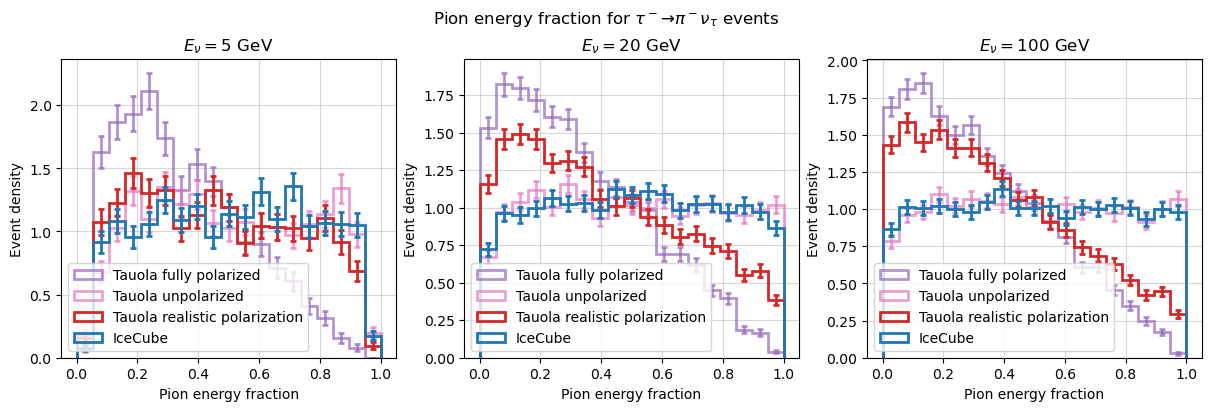

In [8]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, 1, 20) for e in nutau_energies}, filter_func=is_pion_nutau_event, plot_func=tau_visible_e_fraction, 
    xlabel="Pion energy fraction", density=True, errorbar=True, colors=colors, ylabel="Event density",
)
fig.suptitle(r"Pion energy fraction for $\tau^- \to \pi^- \nu_\tau$ events")
for ax in axs.flat:
    ax.legend(loc="lower left")
fig.savefig("../thesis-plots/pi_e_frac_pol.png")

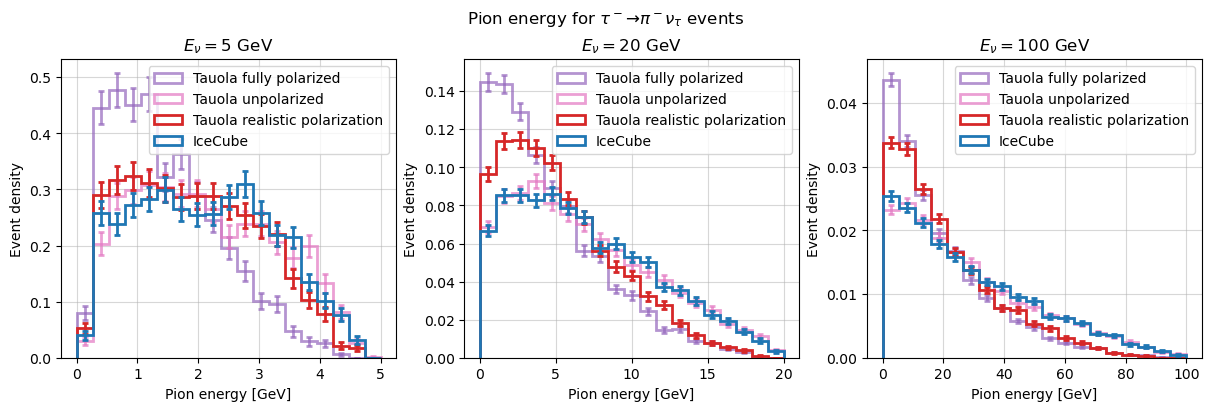

In [9]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, e, 20) for e in nutau_energies}, filter_func=is_pion_nutau_event, plot_func=tau_visible_e, 
    xlabel="Pion energy [GeV]", density=True, errorbar=True, ylabel="Event density", colors=colors,
)
fig.suptitle(r"Pion energy for $\tau^- \to \pi^- \nu_\tau$ events")
fig.savefig("../thesis-plots/pi_e_pol.png")

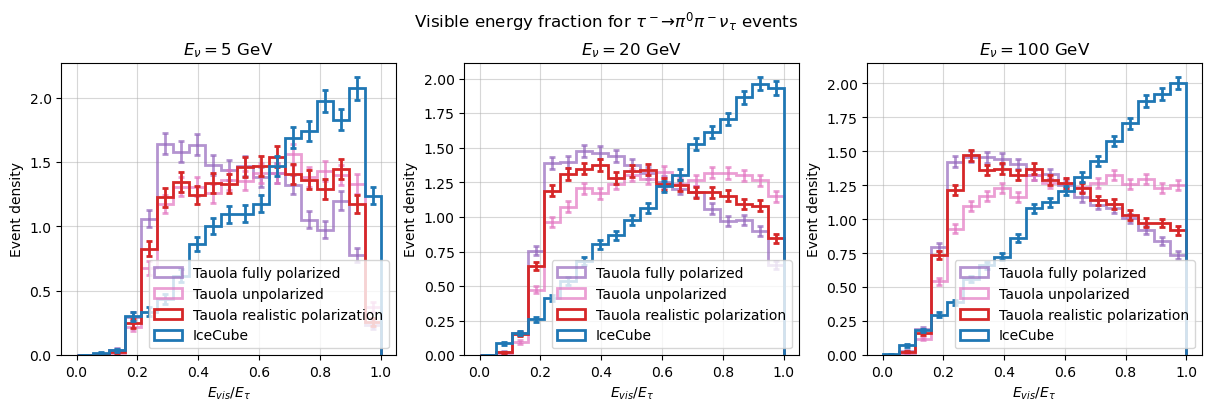

In [12]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, 1, 20) for e in nutau_energies}, 
    filter_func=is_pi0_pim_nutau_event, plot_func=tau_visible_e_fraction, 
    xlabel=r"$E_{vis}/E_\tau$", density=True, errorbar=True, colors=colors, ylabel="Event density"
)

fig.suptitle(r"Visible energy fraction for $\tau^- \to \pi^0 \pi^- \nu_\tau$ events")
fig.savefig("../thesis-plots/pi0pim_e_frac_pol.png")

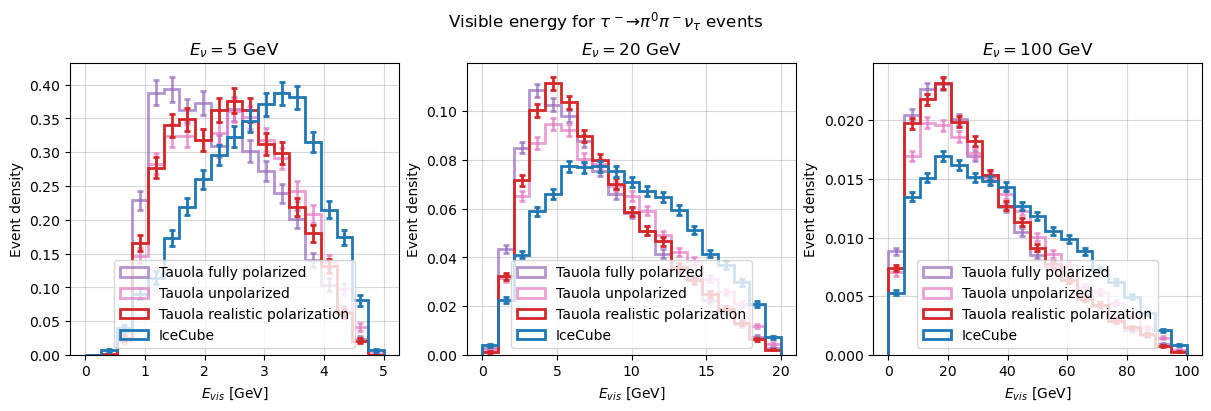

In [14]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, e, 20) for e in nutau_energies}, 
    filter_func=is_pi0_pim_nutau_event, plot_func=tau_visible_e, 
    xlabel=r"$E_{vis}$ [GeV]", ylabel="Event density", density=True, errorbar=True, colors=colors,
)

fig.suptitle(r"Visible energy for $\tau^- \to \pi^0 \pi^- \nu_\tau$ events")
for ax in axs.flat:
    ax.legend(loc="lower center")

fig.savefig("../thesis-plots/pi0pim_e_pol.png")

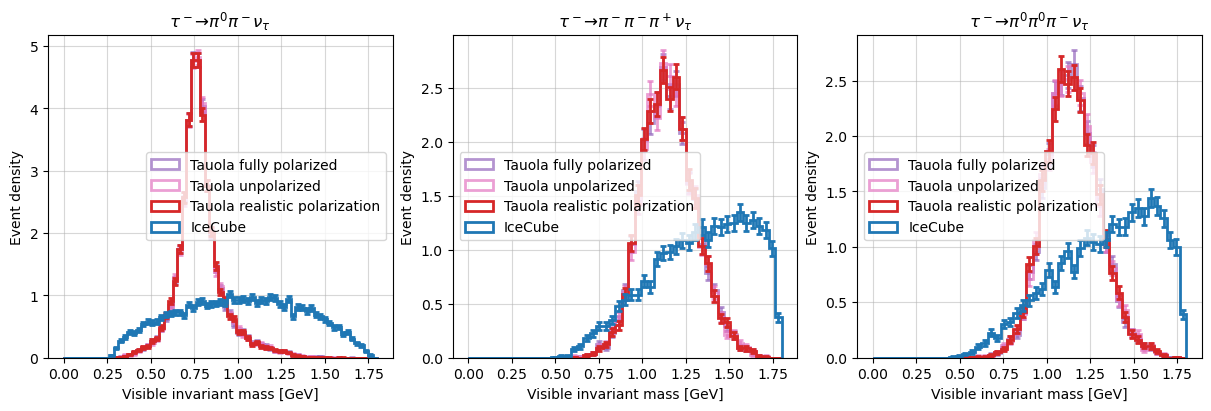

In [54]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), layout="constrained")

plot_histograms(
    {label: {20: d[20]} for label, d in datasets.items()},
    bins={e: np.linspace(0, 1.8, 70) for e in nutau_energies}, axs=[axs[0]],
    filter_func=is_pi0_pim_nutau_event, plot_func=tau_visible_m, 
    xlabel="Visible invariant mass [GeV]", density=True, errorbar=True, ylabel="Event density", colors=colors,
)
axs[0].set(title=r"$\tau^- \to \pi^0 \pi^- \nu_\tau$")
plot_histograms(
    {label: {20: d[20]} for label, d in datasets.items()}, 
    bins={e: np.linspace(0, 1.8, 50) for e in nutau_energies}, axs=[axs[1]],
    filter_func=is_2pim_pip_nutau_event, plot_func=tau_visible_m,
    xlabel=r"Visible invariant mass [GeV]", density=True, errorbar=True, ylabel="Event density", colors=colors, 
)
axs[1].set(title=r"$\tau^- \to \pi^- \pi^- \pi^+ \nu_\tau$")
plot_histograms(
    {label: {20: d[20]} for label, d in datasets.items()}, 
    bins={e: np.linspace(0, 1.8, 50) for e in nutau_energies}, axs=[axs[2]],
    filter_func=is_2pi0_pim_nutau_event, plot_func=tau_visible_m, 
    xlabel=r"Visible invariant mass [GeV]", density=True, errorbar=True, ylabel="Event density", colors=colors,
)
axs[2].set(title=r"$\tau^- \to \pi^0 \pi^0 \pi^- \nu_\tau$")
fig.savefig("../thesis-plots/m_hadrons.png")

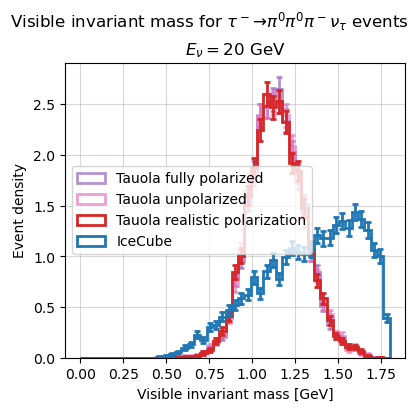

In [ ]:


# axs[-1].axvline(1.020, c="lightgray", ls="--")

axs[0].legend(loc="center left")


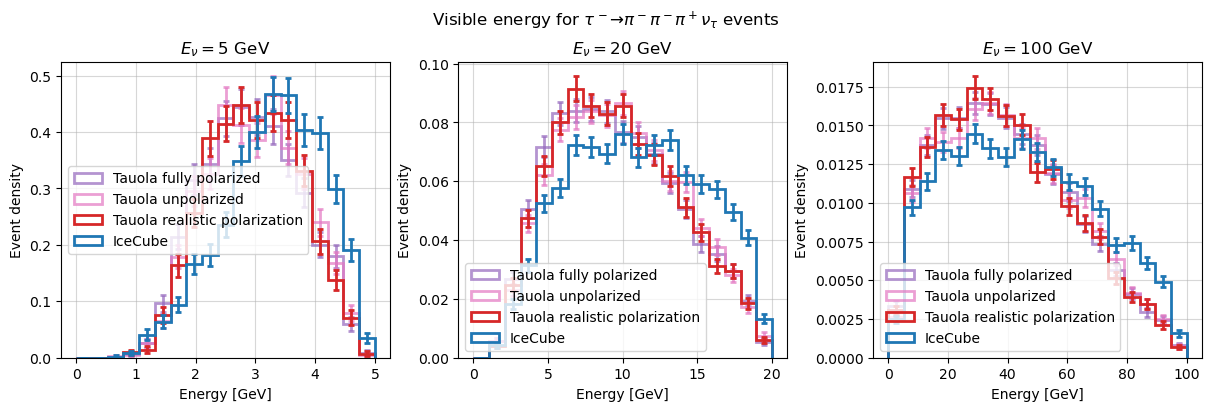

In [17]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, e, 20) for e in nutau_energies}, 
    filter_func=is_2pim_pip_nutau_event, plot_func=tau_visible_e, 
    xlabel="Energy [GeV]", density=True, errorbar=True, ylabel="Event density", colors=colors#title_label=r"$E_\tau$ = {e} GeV",
)
fig.suptitle(r"Visible energy for $\tau^- \to \pi^- \pi^- \pi^+ \nu_\tau$ events")
fig.savefig("../thesis-plots/2pimpip_e_pol.png")

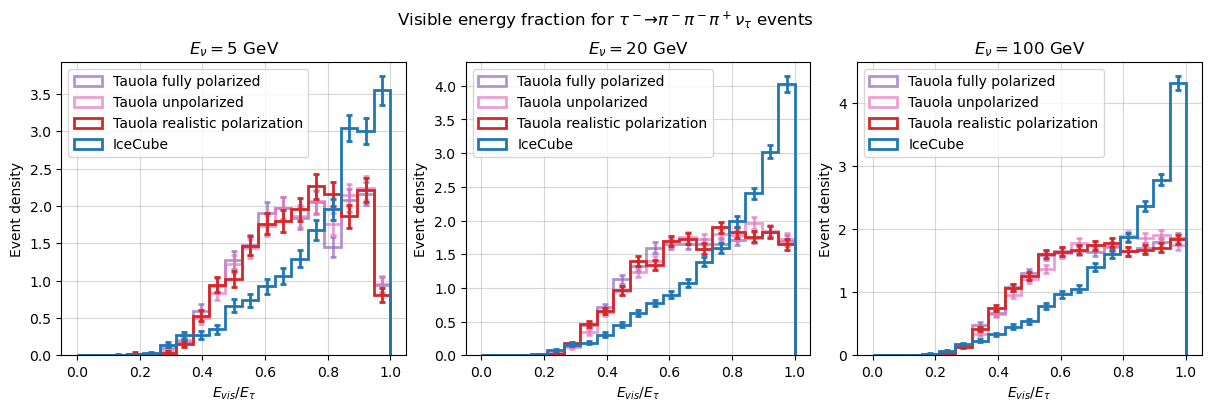

In [18]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, 1, 20) for e in nutau_energies}, 
    filter_func=is_2pim_pip_nutau_event, plot_func=tau_visible_e_fraction, 
    xlabel=r"$E_{vis} / E_\tau$", density=True, errorbar=True, ylabel="Event density", colors=colors,#title_label=r"$E_\tau$ = {e} GeV",
)
fig.suptitle(r"Visible energy fraction for $\tau^- \to \pi^- \pi^- \pi^+ \nu_\tau$ events")
fig.savefig("../thesis-plots/2pimpip_e_frac_pol.png")

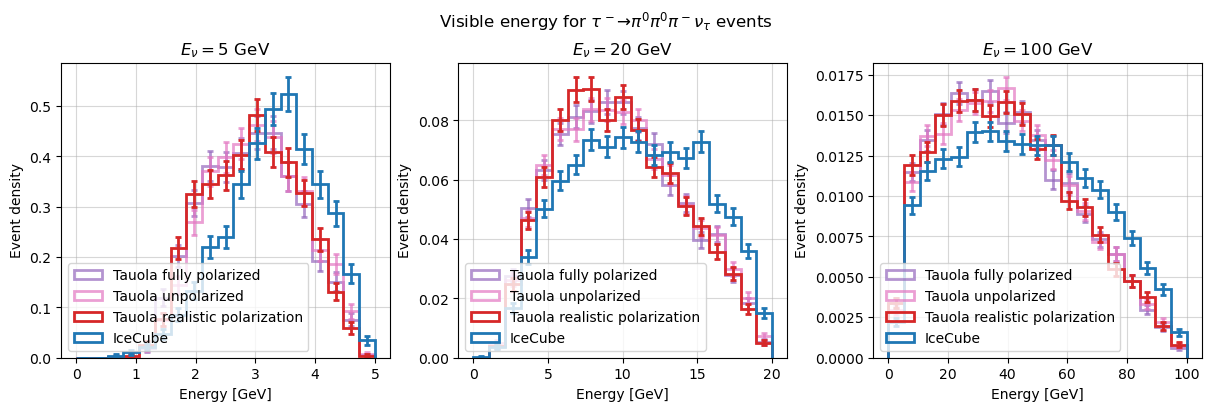

In [19]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, e, 20) for e in nutau_energies}, 
    filter_func=is_2pi0_pim_nutau_event, plot_func=tau_visible_e, 
    xlabel="Energy [GeV]", density=True, errorbar=True, ylabel="Event density", colors=colors,#title_label=r"$E_\tau$ = {e} GeV",
)
fig.suptitle(r"Visible energy for $\tau^- \to \pi^0 \pi^0 \pi^- \nu_\tau$ events")
fig.savefig("../thesis-plots/2pi0pim_e_pol.png")

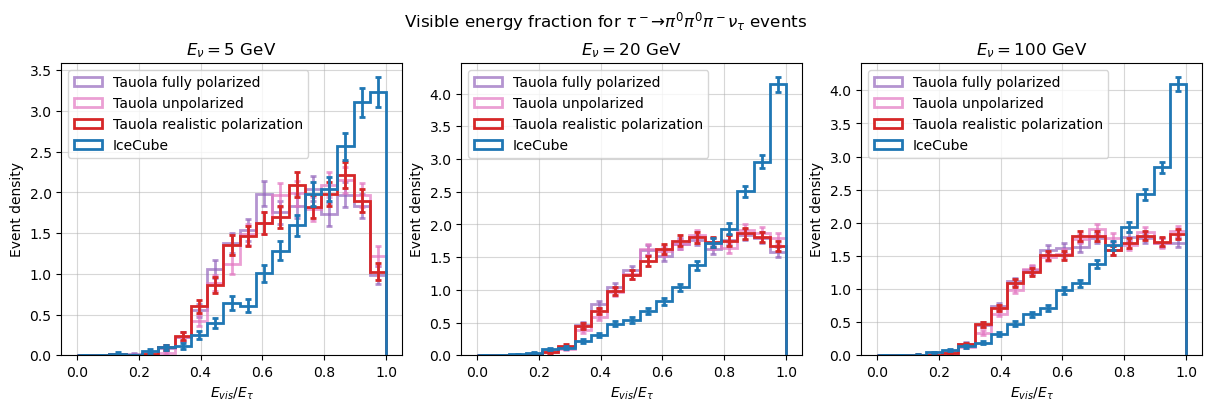

In [20]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, 1, 20) for e in nutau_energies}, 
    filter_func=is_2pi0_pim_nutau_event, plot_func=tau_visible_e_fraction, 
    xlabel=r"$E_{vis}/E_\tau$", density=True, errorbar=True, ylabel="Event density", colors=colors,#title_label=r"$E_\tau$ = {e} GeV",
)
fig.suptitle(r"Visible energy fraction for $\tau^- \to \pi^0 \pi^0 \pi^- \nu_\tau$ events")
fig.savefig("../thesis-plots/2pi0pim_e_frac_pol.png")

In [24]:
def mu_e_fraction(decay_products):
    mu = decay_products.query("pdg == 13")["E"].values
    tau = decay_products.query("pdg == 15")["E"].values
    assert mu.shape == tau.shape
    # print(mu)
    return mu / tau

# Plot the muon angle relative to the tau direction in the tau rest frame
def muon_angle(decay_products):
    muon = decay_products.query("pdg == 13")
    tau = decay_products.query("pdg == 15")
    tau_vec = vector.array({"E": tau["E"], "px": tau["px"], "py": tau["py"], "pz": tau["pz"]})
    muon_vec = vector.array({"E": muon["E"], "px": muon["px"], "py": muon["py"], "pz": muon["pz"]})
    
    muon_vec_boosted = muon_vec.boostCM_of(tau_vec)
    
    return (muon_vec_boosted.pz / muon_vec_boosted.p)

def muon_pol_angle(decay_products, emax_fraction=0):
    # Plot the muon angle relative to the tau direction in the tau rest frame
    muon = decay_products.query("pdg == 13")
    tau = decay_products.query("pdg == 15")
    tau_vec = vector.array({"E": tau["E"], "px": tau["px"], "py": tau["py"], "pz": tau["pz"]})
    muon_vec = vector.array({"E": muon["E"], "px": muon["px"], "py": muon["py"], "pz": muon["pz"]})
    
    muon_vec_boosted = muon_vec.boostCM_of(tau_vec)
    selected_muons = muon_vec_boosted.E > 1.77682/2 * emax_fraction
    delta_angles = np.zeros(selected_muons.shape)
    # Setting all non-high energy muons to nan. Note: this makes the error bars incorrect
    delta_angles[~selected_muons] = np.nan
    delta_angles[selected_muons] = muon_vec_boosted[selected_muons].deltaangle(
        vector.array({"x": tau.polx.values[selected_muons], "y": tau.poly.values[selected_muons], "z": tau.polz.values[selected_muons]}
        )
    )

    return delta_angles
    #muon_vec_boosted.deltaangle(vector.array({"x": tau.polx.values, "y": tau.poly.values, "z": tau.polz.values}))
    #np.arccos(muon_vec_boosted.px * tau.polx.values + muon_vec_boosted.py * tau.poly.values + muon_vec_boosted.pz * tau.polz.values) / muon_vec_boosted.p)



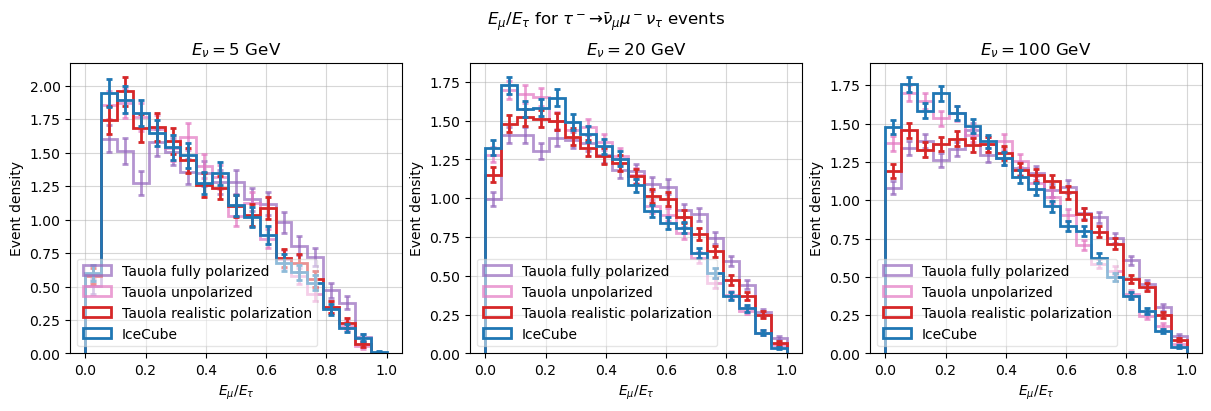

In [25]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, 1, 20) for e in nutau_energies}, 
    filter_func=is_mu_numu_nutau_event, plot_func=tau_visible_e_fraction, 
    xlabel=r"$E_\mu / E_\tau$", density=True, errorbar=True, ylabel="Event density", colors=colors,#title_label=r"$E_\tau$ = {e} GeV",
)
fig.suptitle(r"$E_\mu / E_\tau$ for $\tau^- \to \bar\nu_\mu \mu^- \nu_\tau$ events")
for ax in axs.flat:
    ax.legend(loc="lower left", framealpha=0.5)

fig.savefig("../thesis-plots/mu_e_frac_pol.png")

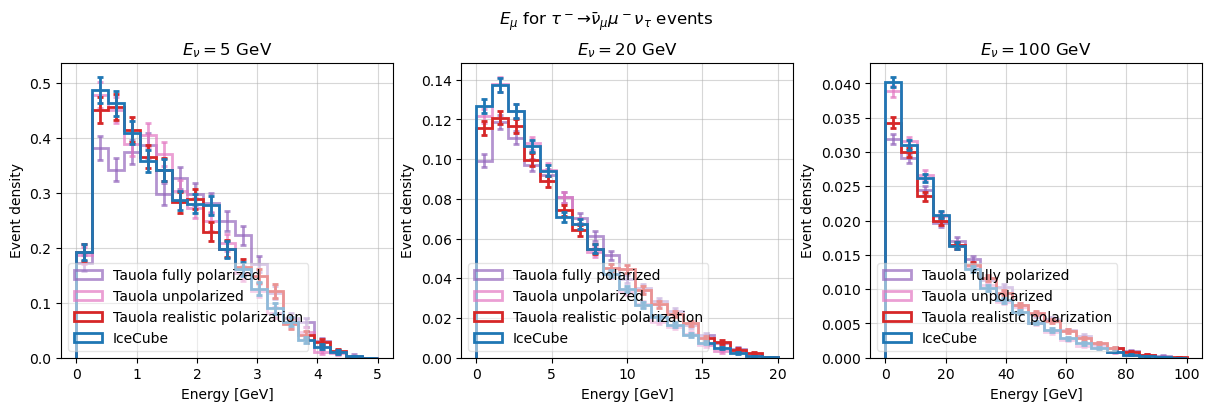

In [26]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, e, 20) for e in nutau_energies}, 
    filter_func=is_mu_numu_nutau_event, plot_func=tau_visible_e, 
    xlabel=r"Energy [GeV]", density=True, errorbar=True, ylabel="Event density", colors=colors,#title_label=r"$E_\tau$ = {e} GeV",
)
fig.suptitle(r"$E_\mu$ for $\tau^- \to \bar\nu_\mu \mu^- \nu_\tau$ events")
for ax in axs.flat:
    ax.legend(loc="lower left", framealpha=0.5)

fig.savefig("../thesis-plots/mu_e_pol.png")

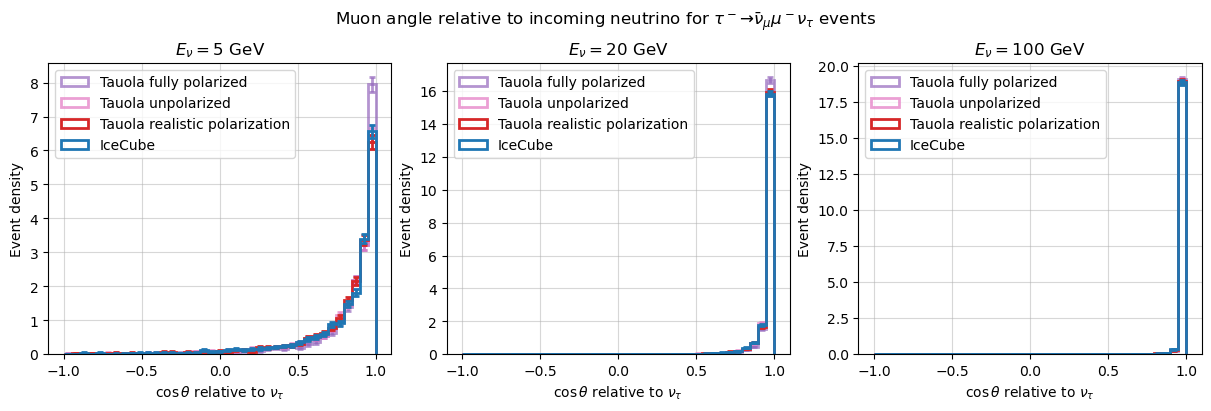

In [31]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(-1, 1, 40) for e in nutau_energies}, filter_func=is_mu_numu_nutau_event, plot_func=lambda df: np.cos(visible_theta(df)), 
    xlabel=r"$\cos\theta$ relative to $\nu_\tau$", errorbar=True, density=True, ylabel="Event density", colors=colors,
)
fig.suptitle(r"Muon angle relative to incoming neutrino for $\tau^- \to \bar\nu_\mu \mu^- \nu_\tau$ events")
fig.savefig("../thesis-plots/mu_costheta_pol.png")

## Angles in rest frame
These plots are to confirm that the polarization is correct.

In [32]:
def visible_tau_rest_frame_costheta(decay_products):
    # Plot the muon angle relative to the tau direction in the tau rest frame
    tau = decay_products.query("pdg == 15").set_index("event_num")[["E", "px", "py", "pz"]]
    
    visible_decay_products = decay_products.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)")
    visible = visible_decay_products.groupby("event_num")[["E", "px", "py", "pz"]].sum()
    
    tau_vec = vector.array({"E": tau["E"], "px": tau["px"], "py": tau["py"], "pz": tau["pz"]})
    visible_vec = vector.array({"E": visible["E"], "px": visible["px"], "py": visible["py"], "pz": visible["pz"]})
    
    visible_vec_boosted = visible_vec.boostCM_of(tau_vec)
    
    return np.cos(visible_vec_boosted.theta)
    
    # selected_events = visible_vec_boosted.E > 1.7768/2
    # delta_angles = np.zeros(selected_events.shape)
    # # Setting all non-high energy muons to nan. Note: this makes the error bars incorrect
    # delta_angles[~selected_events] = np.nan
    # delta_angles[selected_events] = visible_vec_boosted[selected_events].deltaangle(tau_vec[selected_events])
    # return delta_angles
    #visible_vec_boosted.deltaangle(vector.array({"x": tau.polx.values, "y": tau.poly.values, "z": tau.polz.values}))
    #np.arccos(visible_vec_boosted.px * tau.polx.values + visible_vec_boosted.py * tau.poly.values + visible_vec_boosted.pz * tau.polz.values) / visible_vec_boosted.p)


def visible_tau_rest_frame_costheta_particle(decay_products, pdg):
    # Plot the muon angle relative to the tau direction in the tau rest frame
    tau = decay_products.query("pdg == 15").set_index("event_num")[["E", "px", "py", "pz"]]
    
    visible_decay_products = decay_products.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)")
    visible = visible_decay_products.groupby("event_num")[["E", "px", "py", "pz"]].sum()
    
    tau_vec = vector.array({"E": tau["E"], "px": tau["px"], "py": tau["py"], "pz": tau["pz"]})
    visible_vec = vector.array({"E": visible["E"], "px": visible["px"], "py": visible["py"], "pz": visible["pz"]})
    
    visible_vec_boosted = visible_vec.boostCM_of(tau_vec)
    
    return np.cos(visible_vec_boosted.theta)

def visible_e_tau_rest_frame(df):
    # Return the visible energy in the tau rest frame
    visible_decay_products = df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)")
    tau = df.query("pdg == 15").set_index("event_num")[["E", "px", "py", "pz"]]
    visible = visible_decay_products.groupby("event_num")[["E", "px", "py", "pz"]].sum()
    
    tau_vec = vector.array({"E": tau["E"], "px": tau["px"], "py": tau["py"], "pz": tau["pz"]})
    visible_vec = vector.array({"E": visible["E"], "px": visible["px"], "py": visible["py"], "pz": visible["pz"]})
    
    visible_boosted = visible_vec.boostCM_of(tau_vec)
    
    return visible_boosted.E


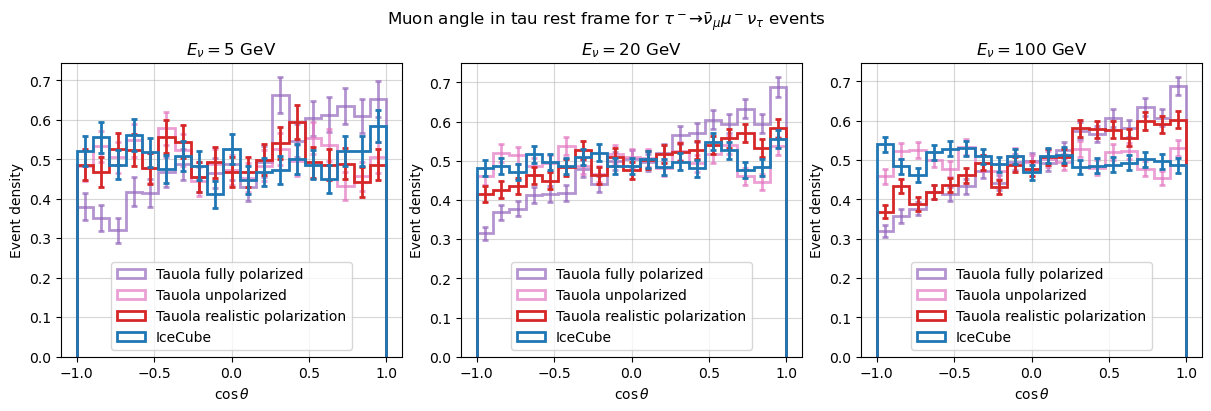

In [30]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(-1, 1, 20) for e in nutau_energies}, filter_func=is_mu_numu_nutau_event, plot_func=visible_tau_rest_frame_costheta, 
    xlabel=r"$\cos\theta$", errorbar=True, density=True, ylabel="Event density", colors=colors,# title_label=r"$E_\tau = {e}$ GeV",
)
fig.suptitle(r"Muon angle in tau rest frame for $\tau^- \to \bar\nu_\mu \mu^- \nu_\tau$ events")
fig.savefig("../thesis-plots/mu_costheta_rest.png")

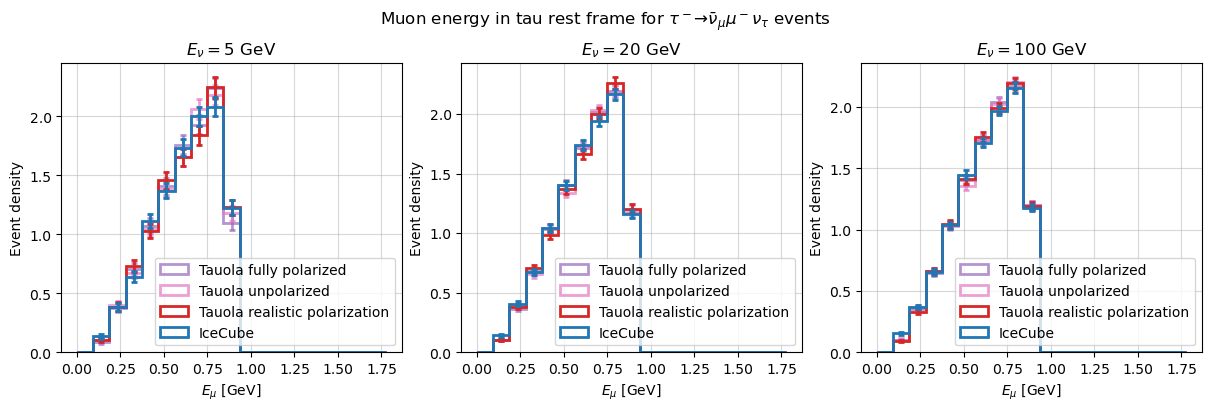

In [32]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, 1.777, 20) for e in nutau_energies}, filter_func=is_mu_numu_nutau_event, plot_func=visible_e_tau_rest_frame, 
    xlabel=r"$E_\mu$ [GeV]", errorbar=True, density=True, ylabel="Event density", colors=colors,# title_label=r"$E_\tau = {e}$ GeV",
)
fig.suptitle(r"Muon energy in tau rest frame for $\tau^- \to \bar\nu_\mu \mu^- \nu_\tau$ events")
fig.savefig("../thesis-plots/mu_e_rest.png")

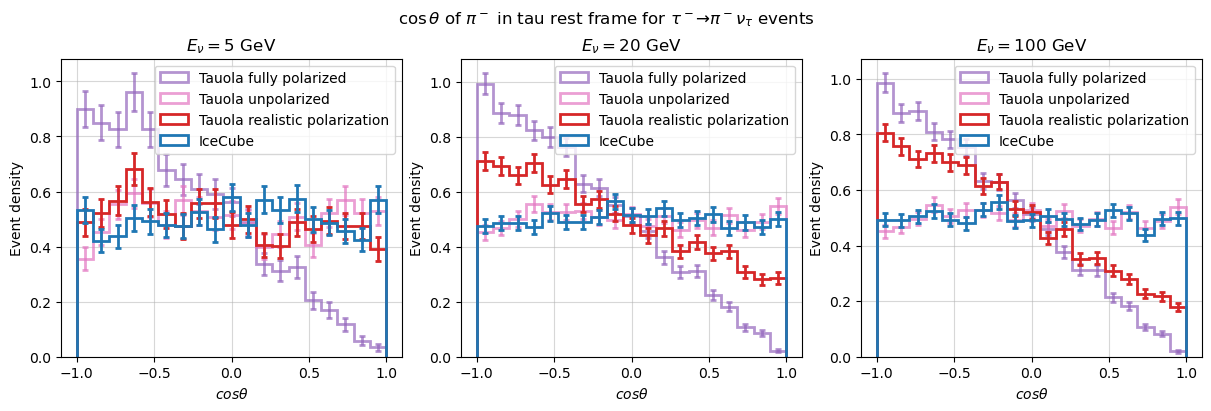

In [34]:
fig, axs = plot_histograms(
    datasets,
    bins={e: np.linspace(-1, 1, 20) for e in nutau_energies}, filter_func=is_pion_nutau_event, plot_func=visible_tau_rest_frame_costheta, 
    xlabel=r"$cos\theta$", errorbar=True, density=True, ylabel="Event density", colors=colors,#title_label=r"$E_\tau = {e}$ GeV",
)
fig.suptitle(r"$\cos\theta$ of $\pi^-$ in tau rest frame for $\tau^- \to  \pi^- \nu_\tau$ events")
fig.savefig("../thesis-plots/pi_costheta_rest_pol.png")

## Cascade-like events
These are all events that are not muon events

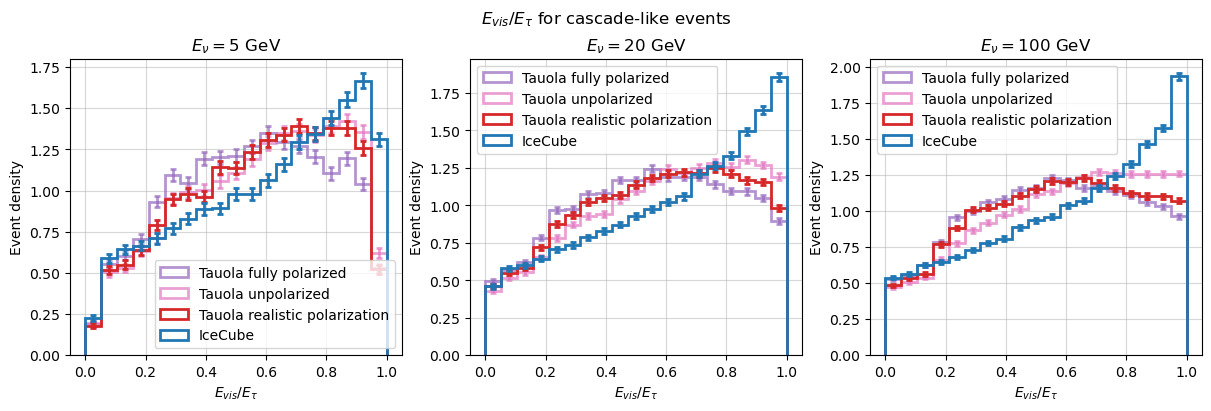

In [35]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, 1, 20) for e in nutau_energies}, 
    filter_func=numba.njit(lambda values, index: not (values == 13).any()), plot_func=tau_visible_e_fraction, 
    xlabel=r"$E_{vis} / E_\tau$", density=True, errorbar=True, ylabel="Event density", colors=colors, #title_label=r"$E_\tau$ = {e} GeV",
)
fig.suptitle(r"$E_{vis} / E_\tau$ for cascade-like events")
fig.savefig("../thesis-plots/cascade_e_frac_pol.png")

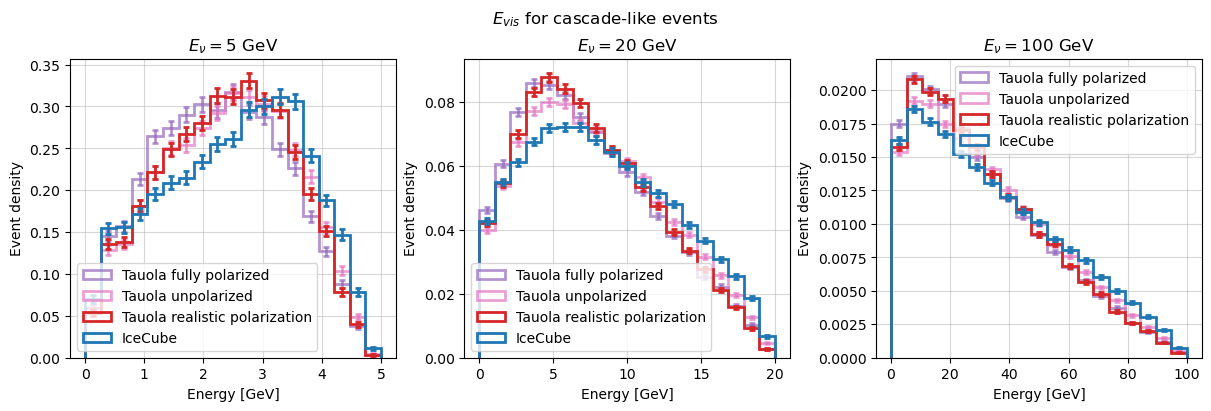

In [37]:
fig, axs = plot_histograms(
    datasets, 
    bins={e: np.linspace(0, e, 20) for e in nutau_energies}, 
    filter_func=numba.njit(lambda values, index: not (values == 13).any()), plot_func=tau_visible_e, 
    xlabel=r"Energy [GeV]", density=True, errorbar=True, ylabel="Event density", colors=colors, #title_label=r"$E_\tau$ = {e} GeV",
)
fig.suptitle(r"$E_{vis}$ for cascade-like events")
fig.savefig("../thesis-plots/cascade_e_pol.png")

## Missing decay modes
Plot the decay modes that are missing from Geant4 but included in Tauola

In [6]:
@numba.njit
def is_missing_decay_mode(values, index):
    return not (
        is_pion_nutau_event(values, index)
        or is_e_nue_nutau_event(values, index)
        or is_mu_numu_nutau_event(values, index)
        or is_pi0_pim_nutau_event(values, index)
        or is_2pim_pip_nutau_event(values, index)
        or is_2pi0_pim_nutau_event(values, index)
    )

@numba.njit
def is_leptonic_event(values, index):
    return (
        ((np.abs(values) == 11).sum() > 0) 
        or ((np.abs(values) == 13).sum() > 0) 
        # or ((np.abs(values) == 15).sum() > 0) 
    )

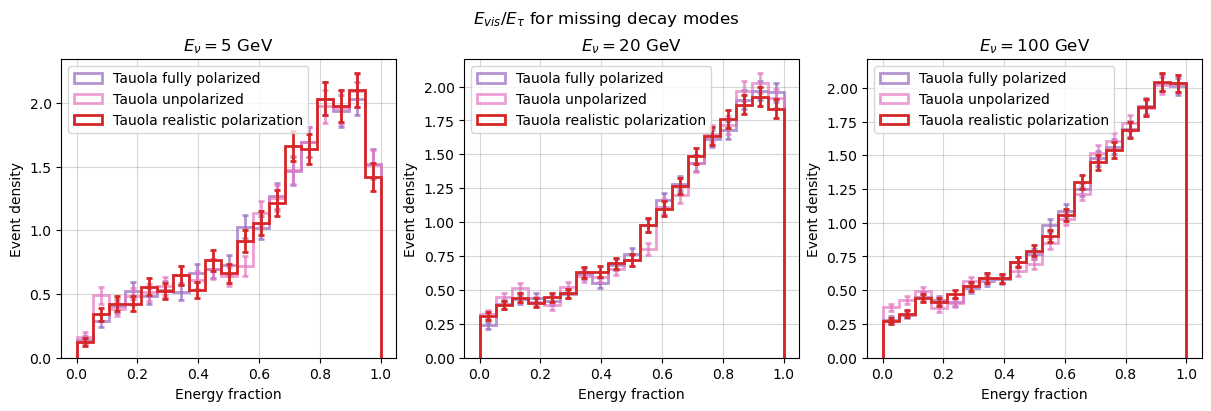

In [39]:
fig, axs = plot_histograms(
    datasets_tauola, 
    bins={e: np.linspace(0, 1, 20) for e in nutau_energies}, 
    filter_func=is_missing_decay_mode, plot_func=tau_visible_e_fraction, 
    xlabel=r"Energy fraction", density=True, errorbar=True, ylabel="Event density", colors=colors, #title_label=r"$E_\tau$ = {e} GeV",
)
fig.suptitle(r"$E_{vis} / E_\tau$ for missing decay modes")
fig.savefig("../thesis-plots/missing_e_frac_pol.png")

## Comparisons with PROPOSAL

### Compare the Geant4 and Tauola distbutions with PROPOSAL distributions

In [33]:
proposal_lab = pd.read_csv("../data/proposal_ehad_etau_lab.csv")
# Normalize such that the integral under the curve is 1
proposal_lab["density"] = proposal_lab["n"] / np.trapz(proposal_lab["n"], proposal_lab["efrac"])

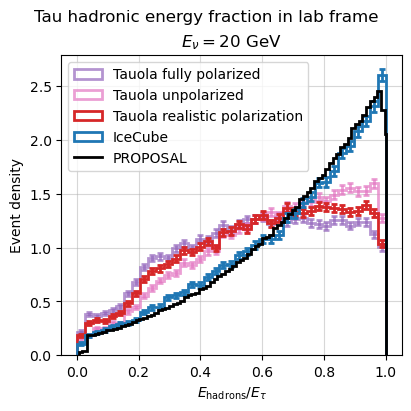

In [34]:
# Plot the decay 
fig, axs = plot_histograms(
    {label: {20: d[20]} for label, d in datasets.items()},
    # {"Tauola": {20: datasets["Tauola unpolarized"][20]}, "Geant4": {20: datasets["IceCube"][20]}},
    bins={e: np.linspace(0, 1, 40) for e in nutau_energies}, 
    filter_func=lambda values, index: (not is_e_nue_nutau_event(values, index)) and (not is_mu_numu_nutau_event(values, index)), 
    plot_func=tau_visible_e_fraction, 
    xlabel=r"$E_\mathrm{hadrons}/ E_\tau$", errorbar=True, colors=colors, density=True, ylabel="Event density", #yscale="log", ylim=(1e-2, 3), title_label="", 
)
fig.suptitle(r"Tau hadronic energy fraction in lab frame")

# Plot PROPOSAL output
axs[0].stairs(proposal_lab["density"], np.r_[proposal_lab["efrac"], proposal_lab["efrac"].iloc[-1]], label="PROPOSAL", color="black", lw=2, zorder=3)
axs[0].legend()
fig.savefig("../thesis-plots/proposal_e_frac.png")

In [35]:
m_tau = 1.77682
proposal_rest = pd.read_csv("../data/proposal_ehad_etau_rest.csv")
proposal_rest["efrac"] *= m_tau
# Normalize such that the integral under the curve is 1
proposal_rest["density"] = proposal_rest["n"] / np.trapz(proposal_rest["n"], proposal_rest["efrac"])

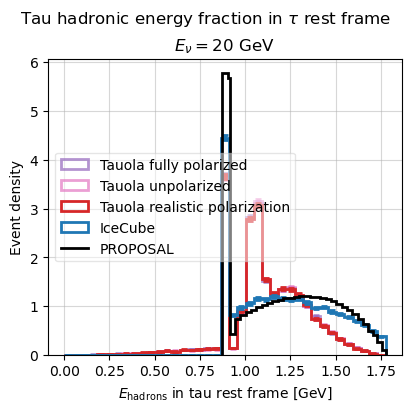

In [36]:
m_tau = 1.777
# Plot the decay 
fig, axs = plot_histograms(
    {label: {20: d[20]} for label, d in datasets.items()},
    bins={e: np.linspace(0, m_tau, 40) for e in nutau_energies}, 
    filter_func=lambda values, index: (not is_e_nue_nutau_event(values, index)) and (not is_mu_numu_nutau_event(values, index)), 
    plot_func=visible_e_tau_rest_frame, 
    xlabel=r"$E_\mathrm{hadrons}$ in tau rest frame [GeV]", errorbar=True, colors=colors, density=True, ylabel="Event density", #yscale="log", title_label="", 
)
fig.suptitle(r"Tau hadronic energy fraction in $\tau$ rest frame")
# Plot PROPOSAL output
axs[0].stairs(proposal_rest["density"], np.r_[proposal_rest["efrac"], m_tau], label="PROPOSAL", color="black", lw=2, zorder=3)
axs[0].legend(loc="center left", framealpha=0.5)
fig.savefig("../thesis-plots/proposal_e_rest.png")

In [37]:
proposal_old_lab = pd.read_csv("../data/proposal_old_ehad_etau_lab.csv")
# Normalize such that the integral under the curve is 1
proposal_old_lab["density"] = proposal_old_lab["n"] / np.trapz(proposal_old_lab["n"], proposal_old_lab["efrac"])

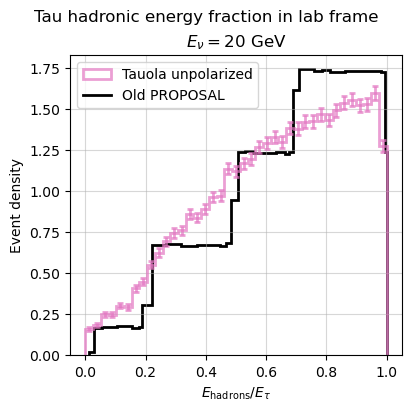

In [40]:
# Plot the decay 
fig, axs = plot_histograms(
    {"Tauola unpolarized": {20: datasets["Tauola unpolarized"][20]}},
    bins={e: np.linspace(0, 1, 40) for e in nutau_energies}, 
    filter_func=lambda values, index: (not is_e_nue_nutau_event(values, index)) and (not is_mu_numu_nutau_event(values, index)), 
    plot_func=tau_visible_e_fraction, 
    xlabel=r"$E_\mathrm{hadrons}/ E_\tau$", errorbar=True, colors=colors, density=True, ylabel="Event density", #title_label="",
)
fig.suptitle(r"Tau hadronic energy fraction in lab frame")

# Plot PROPOSAL output
axs[0].stairs(proposal_old_lab["density"], np.r_[proposal_old_lab["efrac"], 1], label="Old PROPOSAL", color="black", lw=2)
axs[0].legend()
fig.savefig("../thesis-plots/proposal_e_frac_old.png")